In [1]:
#export
import torch, logging, warnings, os, time, re, json, k1lib
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from typing import Any, List, Union, Tuple, Iterator, Dict
from functools import partial

In [2]:
#export
__all__ = ["_docsUrl",
           "textToHtml", "clearLine", "tab", "isNumeric", "close",
           "patch", "wrapMod", "wraps", "squeeze", "raiseEx", "smooth",
           "numDigits", "limitLines",
           "limitChars", "showLog", "cleanDiv", "graph", "digraph",
           "beep", "beepOnAvailable", "executeNb", "dontWrap",
           "positionalEncode", "debounce", "scaleSvg",
           "nbCells"]

In [3]:
#export
_docsUrl = "https://k1lib.github.io"

In [4]:
#export
def textToHtml(text:str) -> str:
    """Transform a string so that it looks the same on browsers
as in `print()`"""
    return text.replace("\n", "<br>").replace(" ", "&nbsp;")
def clearLine():
    """Prints a character that clears the current line"""
    print("\r" + " "*80 + "\r", end="")
def tab(text:Union[list, str]) -> Union[list, str]:
    """Adds a tab before each line. str in, str out. List in, list out"""
    if isinstance(text, str):
        return "\n".join(["    " + line for line in text.split("\n")])
    else: return ["    " + line for line in text]
def isNumeric(x) -> bool:
    """Returns whether object is actually a number"""
    return isinstance(x, (int, float, np.number))
def close(a, b):
    """Returns whether 2 values are really close to each other"""
    if isNumeric(a) and isNumeric(b): return abs(a - b) < 1e-6
    return torch.allclose(torch.tensor(a), torch.tensor(b))

In [5]:
#export
def patch(_class:type, name:str=None, docs:Union[str, Any]=None, static=False):
    """Patches a function to a class/object.

:param _class: object to patch function. Can also be a type
:param name: name of patched function, if different from current
:param docs: docs of patched function. Can be object with defined __doc__ attr
:param static: whether to wrap this inside :class:`staticmethod` or not
:return: modified function just before patching

Intended to be used like this::

    class A:
        def methA(self):
            return "inside methA"

    @k1lib.patch(A)
    def methB(self):
        return "inside methB"
        
    a = A()
    a.methB() # returns "inside methB"

You can do ``@property`` attributes like this::

    class A: pass
    
    @k1lib.patch(A, "propC")
    @property
    def propC(self): return self._propC

    @k1lib.patch(A, "propC")
    @propC.setter
    def propC(self, value): self._propC = value
    
    a = A(); a.propC = "abc"
    a.propC # returns "abc"

The attribute name unfortunately has to be explicitly declared, as I can't
really find a way to extract the original name. You can also do static
methods like this::

    class A: pass
    
    @k1lib.patch(A, static=True)
    def staticD(arg1): return arg1
    
    A.staticD("def") # returns "def"
"""
    def inner(function):
        _docs = docs
        if _docs is not None and not isinstance(_docs, str): _docs = _docs.__doc__
        _docs = _docs or function.__doc__ or _class.__doc__
        _name = name or function.__qualname__.split(".")[-1]
        
        _function = staticmethod(function) if static else function
        _function.__doc__ = _docs; setattr(_class, _name, _function); return _function
    return inner

In [6]:
class A:
    def methA(self): return "inside methA"
@patch(A)
def methB(self): return "inside methB"
@patch(A, name="propC")
@property
def propC(self): return "inside propC"
@patch(A, name="propC")
@propC.setter
def propC(self, value): self.propD = value
@patch(A, static=True)
def staticE(arg1): return arg1
a = A(); assert a.methA() == "inside methA"
assert a.methB() == "inside methB"; assert a.propC == "inside propC"
a.propC = 3; assert a.propD == 3; assert A.staticE(5) == 5

In [7]:
#export
class wrapMod:
    def __init__(self, m, moduleName=None):
        """Wraps around a module, and only suggest symbols in __all__ list
defined inside the module. Example::

    from . import randomModule
    randomModule = wrapMod(randomModule)

:param m: the imported module
:param moduleName: optional new module name for elements (their __module__ attr)"""
        if moduleName is not None:
            for v in m.__dict__.values():
                v.__module__ = moduleName
        self._wrapMod_m = m
        self.__dict__.update(m.__dict__)
        self._wrapMod_extraDirs = []
    def __dir__(self): return self._wrapMod_m.__all__ + self._wrapMod_extraDirs
    def __str__(self): return str(self._wrapMod_m)
    def __repr__(self): return str(self)

In [8]:
#export
def wraps(ogF):
    """Kinda like :meth:`functools.wraps`, but don't update __annotations__."""
    def inner(f):
        f.__doc__ = ogF.__doc__
        f.__name__ = ogF.__name__
        f.__qualname__ = ogF.__qualname__
        f.__module__ = ogF.__module__
        return f
    return inner

In [9]:
#export
def squeeze(_list:Union[list, tuple, torch.Tensor, Any], hard=False):
    """If list only has 1 element, returns that element, else returns original
list.

:param hard: If True, then if list/tuple, filters out None, and takes the first
    element out even if that list/tuple has more than 1 element"""
    if isinstance(_list, (tuple, list)):
        if hard: return [e for e in _list if e != None and e != ""][0]
        elif len(_list) == 1: return _list[0]
    if isinstance(_list, torch.Tensor): return _list.squeeze()
    return _list
def raiseEx(ex:Exception):
    """Raises a specific exception. May be useful in lambdas"""
    raise ex
def smooth(arr:List[float], consecutives:int=5) -> List[float]:
    """Smoothes out array, so that y values are averages of the neighbors"""
    answer = []; s = 0
    for i, elem in enumerate(arr):
        s += elem
        if (i + 1) % consecutives == 0:
            answer.append(s / consecutives); s = 0
    return answer
def numDigits(num) -> int:
    """Get the number of digits/characters of this number/object"""
    return len(f"{num}")
def limitLines(s:str, limit:int=10) -> str:
    """If input string is too long, truncates it and adds ellipsis"""
    splits = s.split("\n")
    if len(splits) > limit: return "\n".join(splits[:limit]) + "\n....."
    else: return s
def limitChars(s:str, limit:int=50):
    """If input string is too long, truncates to first `limit` characters of the first line"""
    if s is None: return ""
    s = f"{s}".split("\n")[0]
    return s[:limit] + "..." if len(s) > limit-3 else s
def showLog(loggerName:str="", level:int=logging.DEBUG):
    """Prints out logs of a particular logger at a particular level"""
    logger = logging.getLogger(loggerName); logger.setLevel(level)
    sh = logging.StreamHandler(); sh.setLevel(logging.DEBUG); logger.addHandler(sh)
def cleanDiv(_list:List[float], total:int) -> List[int]:
    """Cleanly divides :total: into int segments with weights specified by
:_list:. Looks like this: ``(_list / _list.sum()) * total``, but
everything is an ``int``"""
    _list = np.array(_list)
    _list = (_list*total/_list.sum()).astype(int)
    _list[-1] = total - _list[:-1].sum()
    return _list

In [10]:
assert all(cleanDiv([2, 5], 10) == [2, 8])

In [11]:
#export
try:
    import graphviz
    def digraph():
        """Convenience method for creating a new graphviz Digraph.
Example::

    g = k1lib.graph()
    g("a", "b", "c")
    g # displays arrows from "a" to "b" and "a" to "c"
"""
        return graphviz.Digraph(graph_attr={"rankdir":"TB"})
    def graph():
        """Convenience method for creating a new graphviz Graph. See also: :meth:`digraph`"""
        return graphviz.Graph(graph_attr={"rankdir":"TB"})
except ImportError:
    digraph = graph = lambda: print("Module `graphviz` not found! Please install it first, something like `pip install graphviz`")

In [12]:
#export
def beep():
    """Plays a beeping sound, may be useful as notification for long-running tasks"""
    try: import IPython; IPython.core.display.display_html(IPython.display.HTML("""<script>(new Audio('data:audio/wav;base64,UklGRl9vT19XQVZFZm10IBAAAAABAAEAQB8AAEAfAAABAAgAZGF0YU'+Array(1e3).join(123))).play();</script>"""));
    except: os.system("printf '\a'")

In [13]:
#export
def beepOnAvailable(url:str, timeout=5, **kwargs):
    """Tries to connect with a url repeatedly, and if successful, plays
a beep sound"""
    import requests
    try:
        while True:
            time.sleep(1); successful = False
            try:
                if requests.get(url, timeout=timeout, **kwargs).ok:
                    successful = True
            except: pass
            if successful:
                beep(); break
    except KeyboardInterrupt: print("Still not available")

In [14]:
beepOnAvailable("https://google.com")

In [15]:
#export
def executeNb(fileName:str, _globals:dict=None, preserveDir=False):
    """Executes a specified IPython notebook. Can make all variables
defined in the notebook appear in the __main__ context by passing `globals()` in

:param preserveDir: if True, don't change working directory to that of the notebook's"""
    import json, os, traceback
    if _globals is None: _globals = {}
    if not preserveDir:
        oldPath = os.getcwd()
        os.chdir(os.path.dirname(fileName))
    def execute():
        allLines = []
        for cell in json.loads(open(fileName).read())["cells"]:
            if cell["cell_type"] == "code":
                lines = []
                for line in cell["source"]:
                    line = line.rstrip()
                    if line.startswith("!"): continue
                    if line.startswith("%%"): continue
                    lines.append(line)
                    allLines.append(line)
                lines = "\n".join(lines)
                try: exec(lines, _globals); plt.show() # clears plots
                except Exception as e:
                    print("Problematic code block:\n")
                    print(lines); traceback.print_exc();
                    print("All lines:\n")
                    print("\n".join(allLines)); raise e
    execute()
    if not preserveDir: os.chdir(oldPath)
def dontWrap():
    """Don't wrap horizontally when in a notebook. Normally, if you're
displaying something long, like the output of ``print('a'*1000)`` in a notebook,
it will display it in multiple lines. This may be undesirable, so this solves
that by displaying some HTML with css styles so that the notebook doesn't wrap."""
    try:
        from IPython.core.display import display, HTML
        display(HTML("""<style>
    div.jp-OutputArea-output pre {white-space: pre;}
    div.output_area pre {white-space: pre;}
    div.CodeMirror > div.highlight {overflow-y: auto;}
</style>"""))
    except: print("Can't run dontWrap()")

In [16]:
#export
def positionalEncode(t:torch.Tensor, richFactor:float=2) -> torch.Tensor:
    r"""Position encode a tensor of shape :math:`(L, F)`, where :math:`L`
is the sequence length, :math:`F` is the encoded features. Will add the
encodings directly to the input tensor and return it.

This is a bit different from the standard implementations that ppl use.
This is exactly:

.. math:: p = \frac{i}{F\cdot richFactor}
.. math:: w = 1/10000^p
.. math:: pe = sin(w * L)

With ``i`` from range [0, F), and ``p`` the "progress". If ``richFactor`` is 1
(original algo), then ``p`` goes from 0% to 100% of the features. Example::

    import matplotlib.pyplot as plt, torch, k1lib
    plt.figure(dpi=150)
    plt.imshow(k1lib.positionalEncode(torch.zeros(100, 10)).T)

.. image:: images/positionalEncoding.png

:param richFactor: the bigger, the richer the features are. A lot of
    times, I observe that the features that are meant to cover huge scales
    are pretty empty and don't really contribute anything useful. So this
    is to bump up the usefulness of those features"""
    seqN, featsN = t.shape
    feats = torch.tensor(range(featsN)); w = (1/10000**(feats/featsN/richFactor))[None, :].expand(t.shape)
    times = torch.tensor(range(seqN))[:, None].expand(t.shape)
    t[:] = torch.sin(w * times); return t

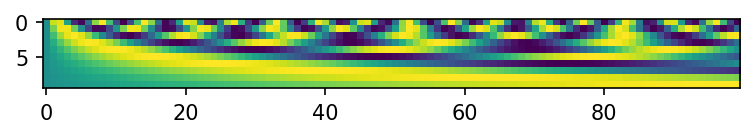

In [17]:
plt.figure(dpi=150); plt.imshow(positionalEncode(torch.zeros(100, 10)).T)

In [18]:
#export
import asyncio, functools
from threading import Timer as ThreadingTimer
class AsyncTimer: # rename if want to use
    def __init__(self, timeout, callback):
        self._timeout = timeout; self._callback = callback
    async def _job(self):
        await asyncio.sleep(self._timeout); self._callback()
    def start(self): self._task = asyncio.ensure_future(self._job())
    def cancel(self): self._task.cancel()
def debounce(wait, threading=False):
    """Decorator that will postpone a function's execution until after
``wait`` seconds have elapsed since the last time it was invoked. Taken
from `ipywidgets <https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html>`_.
Example::

    import k1lib, time; value = 0

    @k1lib.debounce(0.5, True)
    def f(x): global value; value = x**2

    f(2); time.sleep(0.3); f(3)
    print(value) # prints "0"
    time.sleep(0.7)
    print(value) # prints "9"

:param wait: wait time in seconds
:param threading: if True, use multiple threads, else just use async stuff"""
    Timer = ThreadingTimer if threading else AsyncTimer
    def decorator(fn):
        timer = None
        def debounced(*args, **kwargs):
            nonlocal timer
            if timer is not None: timer.cancel()
            timer = Timer(wait, lambda: fn(*args, **kwargs))
            timer.start()
        functools.update_wrapper(debounced, fn); return debounced
    return decorator

In [19]:
import time; value = 0
@debounce(0.5, True)
def f(x): global value; value = x**2
f(2); time.sleep(0.3); f(3); assert value == 0
time.sleep(0.7); assert value == 9

In [20]:
#export
def scaleSvg(svg:str, scale:float) -> str:
    """Scales an svg xml string by some amount."""
    wS = w = re.findall("width=\"\d*pt\"", svg)[0]
    hS = w = re.findall("height=\"\d*pt\"", svg)[0]
    w = int(int(re.findall("\d+", wS)[0])*scale)
    h = int(int(re.findall("\d+", hS)[0])*scale)
    svg = re.sub(wS, f'width="{w}pt"', svg)
    svg = re.sub(hS, f'height="{h}pt"', svg)
    return svg

In [21]:
#export
def nbCells(source:str) -> Iterator[Dict]:
    """Gets simplified notebook cells from file source, including fields
``cell_type`` and ``source`` only. Example::

    k1lib.nbCells(cat("file.ipynb") | join())"""
    js = json.loads(source)
    cells = []; fields = set(["cell_type", "source"])
    return [{k:cell[k] for k in cell.keys() if k in fields} for cell in js["cells"]]

In [22]:
from k1lib.cli import *
assert len(nbCells(cat("_higher.ipynb") | join())) > 0

In [23]:
!../export.py _basics

Current dir: /home/kelvin/repos/labs/k1lib, ../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 0.10
Uninstalling k1lib-0.10:
  Successfully uninstalled k1lib-0.10
running install
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.txt
writing manifest file 'k1lib.egg-info/SOURCES.txt'
reading manifest file 'k1lib.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'k1lib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/k1lib
copying k1lib/_learner.py -> build/lib/k1lib
copying k1lib/fmt.py -> build/lib/k1lib
copying k1lib/_context.py -> build/lib/k1lib
copying k1lib/selector.py -> build/li